<a href="https://colab.research.google.com/github/cis9650group7-boop/Group-7_Project1_HealthRateAnalysis/blob/main/term_project_group7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Analysis of Health Rate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Author: CIS 9650 Group 7 (Anish Bijusoman, Ivana Sundararao, Qingrong Tan, Reem Hussein)
### Date : November 28th, 2025

## Executive Summary

## Table of Contents

1. Introduction
2. Problem Statement / Research Question
3. Data Description
4. Setup and Environment
5. Data Loading
6. Data Preparation
7. Model Planning
8. Model Building / Analysis
9. Discussion & Interpretation
10. Conclusion
11. References
12. Appendix

## Introduction

## Problem Statement / Research Question

## Data Description

## Setup and Environment

In [ ]:
!pip install google-cloud-storage

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px
import json
import os
from google.cloud import storage
from io import BytesIO
from collections import Counter


## Data Loading

### Functions

In [ ]:
from google.cloud import storage

def list_public_bucket(bucket_name, course, project):
    prefix = f"{course}/Project {project}/"

    client = storage.Client.create_anonymous_client()
    bucket = client.bucket(bucket_name)
    blobs = client.list_blobs(bucket, prefix=prefix)
    print(f"Listing files in public bucket '{bucket_name}' under '{prefix}':")
    filenames = []
    for blob in blobs:
        print(blob.name)
        filenames.append(blob.name)

    return filenames

In [ ]:
from google.cloud import storage
import pandas as pd
from io import BytesIO
import os
import json

def gcs_file_to_dataframe(bucket_name: str, blob_path: str, use_cols:list):

    # Anonymous client for public buckets
    client = storage.Client.create_anonymous_client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_path)

    # Download file content as bytes
    data = blob.download_as_bytes()

    # Only read columns we use
    df = pd.read_csv(BytesIO(data),usecols = use_cols)

    return df

In [ ]:
# Set bucket parameters for "msba-online-data/CIS9650/Project 01"
BUCKET_NAME = "msba-online-data"
PROJECT_NUMBER = "01"
COURSE = "CIS9650"
healthrate_raw = list_public_bucket(BUCKET_NAME,COURSE,PROJECT_NUMBER)

Listing files in public bucket 'msba-online-data' under 'CIS9650/Project 01/':
CIS9650/Project 01/
CIS9650/Project 01/healthrate.ratemd.ny.csv


In [ ]:
# Load the csv file into a Pandas dataframe

#List the columns needed to load
columns_load = ["_id",
                "full_name",
                "specialty_name",
                "location.city.name",
                 "rating.average",
                 "rating.helpfulness",
                 "rating.punctuality",
                  "rating.staff",
                 "rating.count",
                "sample_rating_comment"]

csv_path = healthrate_raw[1]
df = gcs_file_to_dataframe(BUCKET_NAME,  csv_path, columns_load)

print(df.head())
print(f'Rows:{len(df)}')


                        _id              full_name location.city.name  \
0  647e89e399dca372f92a0d7c    Dr. Janan S. Sayyed      New York City   
1  647e89e499dca372f92a0d91      Dr. Shirin Peters      New York City   
2  647e89e499dca372f92a0db9      Thomas J. Mulhern      New York City   
3  647e89e499dca372f92a0dba            Zina Rutkin         Great Neck   
4  647e89e499dca372f92a0dbd  Dr. John S. Cavallaro           Brooklyn   

   rating.average  rating.staff  rating.punctuality  rating.helpfulness  \
0        4.989221       4.99005            4.985075            4.993367   
1        5.000000       5.00000            5.000000            5.000000   
2        0.000000       0.00000            0.000000            0.000000   
3        0.000000       0.00000            0.000000            0.000000   
4        0.000000       0.00000            0.000000            0.000000   

   rating.count                              sample_rating_comment  \
0           603  I had chiropractic adju

## Data Preparation

The raw data set from the CSV file contained 1,611 columns and 143,791 rows. That in itself is too much to analyze, and also contained fields such as images, phone numbers, etc... Field that would be irrelivant to our analysis, and research question. So this calls for some data cleaning!

* We selected a focused subset of relevant variables that describe each doctor’s name, specialty, city,core rating metrics, ect.

* We renamed the columns to simpler names. Column names were written such as "location.city.name", "rating.average" so we changed them to "city" and "rating_average"

* Rating fields were stored as mixed text/numeric types so we converted the rating columns to numeric using pd.to_numeric(df_clean[col], errors="coerce")

* We filtered out zero rating doctors to make sure we only analyze doctors who have actual patient reviews in order to produce valid insights

* After filtering, we reset the index for smooth readability.

In [ ]:
# ---------- DATA CLEANING ----------
# Select usable columns
cols_to_keep = [
    "_id", "full_name", "specialty_name", "location.city.name",
    "rating.average", "rating.helpfulness", "rating.punctuality",
    "rating.staff", "rating.count","sample_rating_comment"
]

df_clean = df[cols_to_keep].copy()

# Rename columns to simpler names
df_clean = df_clean.rename(columns={
    "location.city.name": "city",
    "rating.average": "rating_avg",
    "rating.helpfulness": "rating_help",
    "rating.punctuality": "rating_punctuality",
    "rating.staff": "rating_staff",
    "rating.count": "rating_count"
})

# Convert numeric columns to proper numeric types
numeric_cols = [
    "rating_avg", "rating_help", "rating_punctuality",
    "rating_staff", "rating_count"
]

for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

# Drop rows with no rating information
df_clean = df_clean.dropna(subset=["rating_avg"])

# Before having this the rating avg and rating_help was 0's
df_clean = df_clean[df_clean["rating_count"] > 0]
df_clean = df_clean[df_clean["rating_avg"] > 0]

# Reset index
df_clean = df_clean.reset_index(drop=True)

df_clean.head() # this is to see the clean data

,_id,full_name,specialty_name,city,rating_avg,rating_help,rating_punctuality,rating_staff,rating_count,sample_rating_comment
0,647e89e399dca372f92a0d7c,Dr. Janan S. Sayyed,Chiropractor,New York City,4.989221,4.993367,4.985075,4.99005,603,I had chiropractic adjustments and it was gre...
1,647e89e499dca372f92a0d91,Dr. Shirin Peters,Internist / Geriatrician,New York City,5.000000,5.000000,5.000000,5.00000,48,If your looking for an internist who will trea...
2,647e89e499dca372f92a0e14,Dr. Lev L. Barats,Internist / Geriatrician,Slingerlands,4.000000,3.800000,4.100000,3.80000,10,Dr. Barats is very friendly and intelligent. H...
3,647e89e499dca372f92a0ef0,Dr. Harold N. Bornstein,Internist / Geriatrician,New York City,4.000000,4.200000,3.800000,4.20000,10,He should be fired for revealing confidential ...
4,647e89e499dca372f92a0ef2,Dr. Romelle J. Maloney,Gynecologist (OBGYN),New Rochelle,4.000000,3.900000,4.100000,3.80000,10,"Dr. Maloney, It was wonderful to meet you. Y..."


In [ ]:
df.head(10) # this is unclean data

,_id,full_name,location.city.name,rating.average,rating.staff,rating.punctuality,rating.helpfulness,rating.count,sample_rating_comment,specialty_name
0,647e89e399dca372f92a0d7c,Dr. Janan S. Sayyed,New York City,4.989221,4.99005,4.985075,4.993367,603,I had chiropractic adjustments and it was gre...,Chiropractor
1,647e89e499dca372f92a0d91,Dr. Shirin Peters,New York City,5.000000,5.00000,5.000000,5.000000,48,If your looking for an internist who will trea...,Internist / Geriatrician
2,647e89e499dca372f92a0db9,Thomas J. Mulhern,New York City,0.000000,0.00000,0.000000,0.000000,0,NaN,Psychologist
3,647e89e499dca372f92a0dba,Zina Rutkin,Great Neck,0.000000,0.00000,0.000000,0.000000,0,NaN,Psychologist
4,647e89e499dca372f92a0dbd,Dr. John S. Cavallaro,Brooklyn,0.000000,0.00000,0.000000,0.000000,0,NaN,Dentist
5,647e89e499dca372f92a0dc3,Dr. Keith P. Gutzmann,Howard Beach,0.000000,0.00000,0.000000,0.000000,0,NaN,Chiropractor
6,647e89e499dca372f92a0de4,Dr. Aruna Mishra,New York City,0.000000,0.00000,0.000000,0.000000,0,NaN,Gynecologist (OBGYN)
7,647e89e499dca372f92a0df1,Dr. Jonathan D. Porter,Syracuse,0.000000,0.00000,0.000000,0.000000,0,NaN,Dentist
8,647e89e499dca372f92a0dfe,Dr. Andrzej Riess,New York City,0.000000,0.00000,0.000000,0.000000,0,NaN,Gynecologist (OBGYN)
9,647e89e499dca372f92a0e14,Dr. Lev L. Barats,Slingerlands,4.000000,3.80000,4.100000,3.800000,10,Dr. Barats is very friendly and intelligent. H...,Internist / Geriatrician


## Model Planning
### Palce codes for Agregate, Sum, Average, counts

### Model Planning for Insight 1: Specialty-Level Rating Variation and Insights from Patient Feedback


In [ ]:
# Model Planning for Insight 1:Specialty-Level Rating Variation and Insights from Patient Feedback

# ------- Calculations ------

# 1.Create a working copy
specialty_df = df_clean.copy()
print("--- Starting Weighted Agrregation Calculation---")

# 2. Calculate Weighted Sum (Score Points)
# Weighted Sum = Average Rating * Rating Count
specialty_df['weighted_sum'] = specialty_df['rating_avg'] * specialty_df['rating_count']

#3. Calculate the summary for each specialty
specialty_grouped_df = specialty_df.groupby('specialty_name')
specialty_result_df = specialty_grouped_df.agg(
    total_score_sum =('weighted_sum','sum'),  # Total Score Points for a specialty
    total_count = ('rating_count','sum'), # Toal rating_count for a specialty
    num_doctors = ('_id','nunique') # Total numbers of doctors for a specialty
)

#4. Reset the index
specialty_result_df = specialty_result_df.reset_index()

#5. Calculate weighted average rating
specialty_result_df['final_average_rating'] = specialty_result_df['total_score_sum'] / specialty_result_df['total_count']


# ------ Filter out outliers (specialties with very low rating counts - bottom 10th percentile) ------

# 1. Calculate the percentle threshold for total_count
threshold_percentile = specialty_result_df['total_count'].quantile(0.25) #25%
print(f"The 25th percentile rating count threshold: {threshold_percentile}")

# 2. Apply the filter
specialty_result_df = specialty_result_df[specialty_result_df['total_count'] >= threshold_percentile]

# 3. Rank the remaning specialties (final_average_rating DESC).
specialty_result_df = specialty_result_df.sort_values(by = 'final_average_rating', ascending = False)

#print(specialty_result_df)


--- Starting Weighted Agrregation Calculation---
The 25th percentile rating count threshold: 165.25


## Model building / Analysis

###Model building for Insight 1: Specialty-Level Rating Variation and Insights from Patient Feedback


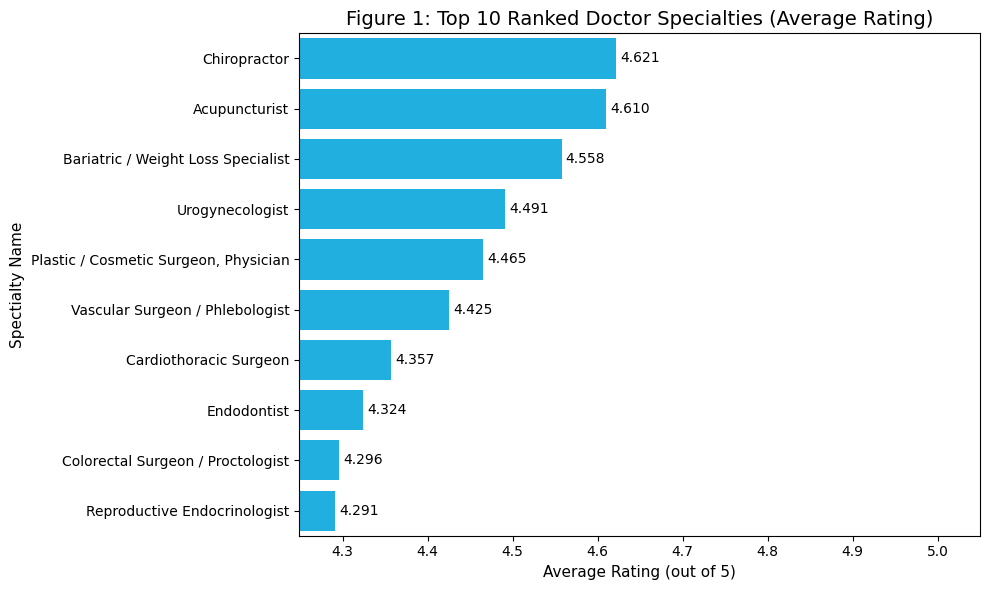

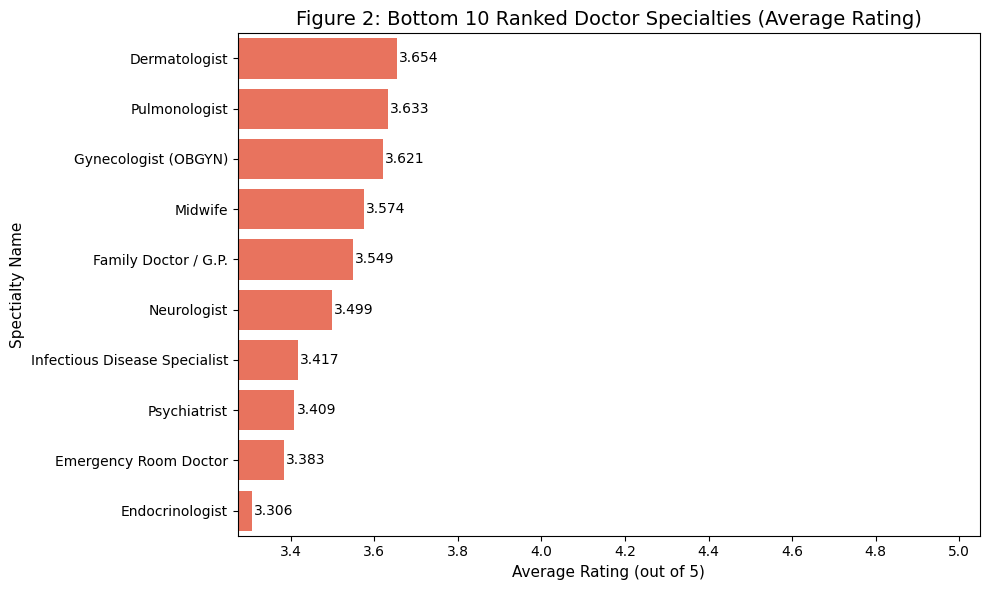

In [ ]:
# Model building for Insight 1: the differences in doctor ratings across different specialties
# specialty_result_df is the dataframe already containing rows order by final_average_rating DESC

# Top 10 Bar Chart
# 1. Prepare Top 10 df
top_10_df = specialty_result_df.head(10).copy()

# 2. Sort the plotting data by rating ASC for correct chart display
top_10_df = top_10_df.sort_values(by='final_average_rating', ascending=True)

#3. Create Top 10 Horizontal Bar Chart
plt.figure(figsize=(10,6))
sns.barplot(
    x = 'final_average_rating',
    y = 'specialty_name',
    data = top_10_df,
    color = 'deepskyblue'
)
plt.title('Figure 1: Top 10 Ranked Doctor Specialties (Average Rating)', fontsize = 14)
plt.xlabel('Average Rating (out of 5)', fontsize = 11)
plt.ylabel('Spectialty Name', fontsize = 11)

# Add value for each bar
for index, value in enumerate(top_10_df['final_average_rating']):
  plt.text(
      value + 0.005,
      index,
      f'{value:.3f}',
      ha = 'left',
      va = 'center',
      fontsize = 10
  )

# Invert the y-axis to show the highest rated specialty at the top
plt.gca().invert_yaxis()
plt.xlim(top_10_df['final_average_rating'].min() * 0.99, 5.05)
plt.tight_layout()
plt.show()



# Bottom 10 Bar Chart
# 1. Prepare bottom 10 df
bottom_10_df = specialty_result_df.tail(10).copy()

# 2. Sort the plotting data by rating ASC for correct chart display
bottom_10_df = bottom_10_df.sort_values(by='final_average_rating', ascending=True)

#3. Create Bottom 10 Horizontal Bar Chart
plt.figure(figsize=(10,6))
sns.barplot(
    x = 'final_average_rating',
    y = 'specialty_name',
    data = bottom_10_df,
    color = 'tomato'
)
plt.title('Figure 2: Bottom 10 Ranked Doctor Specialties (Average Rating)', fontsize = 14)
plt.xlabel('Average Rating (out of 5)', fontsize = 11)
plt.ylabel('Spectialty Name', fontsize = 11)

# Add value for each bar
for index, value in enumerate(bottom_10_df['final_average_rating']):
  plt.text(
      value + 0.005,
      index,
      f'{value:.3f}',
      ha = 'left',
      va = 'center',
      fontsize = 10
  )

# Invert the y-axis to show the highest rated specialty at the top
plt.gca().invert_yaxis()
plt.xlim(bottom_10_df['final_average_rating'].min() * 0.99, 5.05)
plt.tight_layout()
plt.show()





###Analysis for Insight 1: What do patients talk about? (sample_rating_comment)

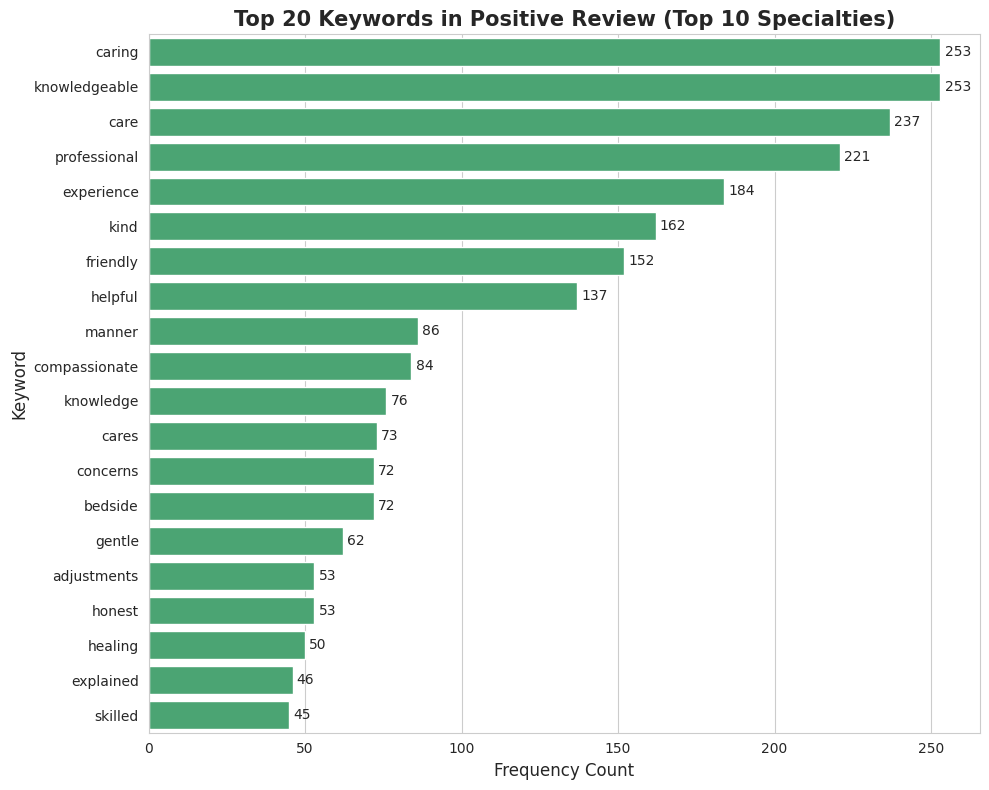

In [ ]:
# Analysis of Top 10 Specialties' Positive Keywords

# 1. Create a dataframe for comment analysis
comments_df = df_clean.copy()

# 2. Get the list of top 10 specialty name
top_10_names = specialty_result_df.head(10)['specialty_name'].tolist()
#print(f'Top 10 Specialties: {top_10_names}')

# 3. Filter Data:
top_10_reviews = comments_df[
    (comments_df['specialty_name'].isin(top_10_names)) &
    (comments_df['rating_avg'] >= 4.29) &
    (comments_df['sample_rating_comment'].notna())

    ]
#print(f'Number of comments extracted: {len(top_10_reviews)}')

# 4. Combine all comments into one large string
all_text = ' '.join(top_10_reviews['sample_rating_comment'].astype(str).tolist())

# 5. Convert to lowercase, replace any charaters that is not a word charater or a whitespace charater
all_text = re.sub(r'[^\w\s]',' ', all_text).lower()

# 6. A set of common words that need to ignore
words_to_ignore = {'the','and','to','a','of','was','is','in','for','my','she','he','it','with','very','that',
    'at','on','her','his','i','me','you','are','we','they','them','our','your','there','anyone','being',
    'dr','doctor','doctors','patient','patients','office','staff','visit','appointment','time','day',
    'year','years','person','issues','everything','health','thank','thanks','please',
    'great','good','best','better','excellent','amazing','wonderful','fantastic','awesome','incredible',
    'truly','happy','comfortable','really','so','too','quite','super','extremely','well','first','only','just',
    'even','still','then','than','now','ever','never','enough','made','make','get','got','give','gave','take','took','felt','feel','went','came','see','seen','say',
    'says','said','look','looks','know','knew','done','did','does','doing','help','helped','helps','able','need','needs','like','liked','likes','want','wanted','wanting',
    'but','and','or','if','when','while','because','also','just','even','only','still','then','than',
    'though','however','although','from','this','that','these','those','about','around','after','before',
    'over','under','into','out','one','will','can','could','would','were','been','has','have','had','not','many','much','any','every','few','lot','lots','more','most','some','several','again',
    'who','what','how','where','why','which','him','amp','work','having','seeing','found','treated','needed','without','visits','things','sure',
    'during','since','ago','new','weeks','months','free','friends','everyone','team',
    'feeling','all','highly','always','other','going','family','take','through','results','life','their','body','recommend','recommended','takes','way','right','thorough','ploblem',	'both','don','two','times','long','each','entire','down','left','such',
    'people','practice','job','love','easy','tell','come','gone','met','looking','explain','definitely','absolutely','next','makes','whole','should','process',
    'lower','far','same','else','positive','saw','face','root','plastic','knowledgable','nice','questions','pain','back','surgery','treament','chiropractor','surgeon','neck','chiropractic','procedure','treatment','treatments',
    'acupuncture','problems','problem','chiropractors','medical','breast','acupuncturist','hands','therapy','relief'
    }

# 7. Split
comment_words = all_text.split()

# 8. Filter: Keep words not in words_to_ignore and longer than 2 charaters
meaningful_words = [mw for mw in comment_words if mw not in words_to_ignore and len(mw) > 2 ]

# 9. Count the top 20 most frequent words
word_counts = Counter(meaningful_words)
top_keywords_df = pd.DataFrame(word_counts.most_common(20), columns = ['Keyword','Frequency'])
#print(top_keywords_df)

# 10. Chart
sns.set_style('whitegrid')  # Set the visual style for the plot
plt.figure(figsize=(10,8))  # Set the font size of the chart

# Creat a horizontal bar plot
ax = sns.barplot(
    x = 'Frequency',
    y = 'Keyword',
    data = top_keywords_df,
    color = 'mediumseagreen'
)

# Add title and lables
plt.title('Top 20 Keywords in Positive Review (Top 10 Specialties)', fontsize = 15, fontweight = 'bold')
plt.xlabel('Frequency Count',fontsize = 12)
plt.ylabel('Keyword', fontsize = 12)

# Add the frequency number at the end of each bar
for inumber in ax.containers:
  ax.bar_label(inumber,padding = 3)

plt.tight_layout()
plt.show()






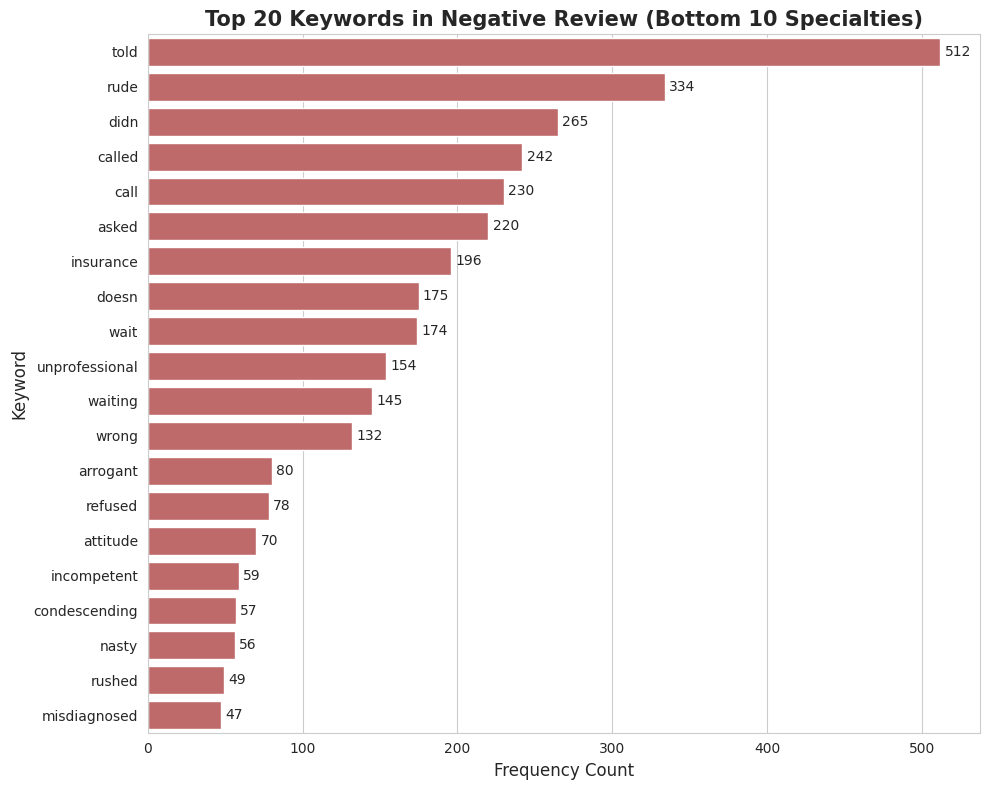

In [ ]:
#Analysis of Bottom 10 Specialties' Negative Keywords
# 1. Create a dataframe for comment analysis
comments_df2 = df_clean.copy()

# 2. Get the list of bottom 10 specialty name
bottom_10_names = specialty_result_df.tail(10)['specialty_name'].tolist()
#print(f'Bottom 10 Specialties: {bottom_10_names}')

# 3. Filter Data: Focus on Bottom 10 + Low Ratings (<= 2.5)
bottom_10_reviews = comments_df2[
    (comments_df2['specialty_name'].isin(bottom_10_names)) &
    (comments_df2['rating_avg'] <= 2.5) &
    (comments_df2['sample_rating_comment'].notna())
]
#print(f'Number of negative comments extracted: {len(bottom_10_reviews)}')

# 4. Combine all comments into one large string
all_text2 = ' '.join(bottom_10_reviews['sample_rating_comment'].astype(str).tolist())

# 5. Convert to lowercase, replace any characters that is not a word character or a whitespace character
all_text2 = re.sub(r'[^\w\s]',' ', all_text2).lower()

# 6. A set of common words that need to ignore
words_to_ignore2 = {
    'the','and','to','a','of','was','is','in','for','my','she','he','it','with','very','that',
    'at','on','her','his','i','me','you','are','we','they','them','our','your','there','anyone','being',
    'dr','doctor','doctors','patient','patients','office','staff','visit','appointment','time','day',
    'year','years','person','issues','everything','health','thank','thanks','please',
    'truly','happy','comfortable','really','so','too','quite','super','extremely','well','first','only','just',
    'even','still','then','than','now','ever','never','enough','made','make','get','got','give','gave','take','took','felt','feel','went','came','see','seen','say',
    'says','said','look','looks','know','knew','done','did','does','doing','help','helped','helps','able','need','needs','like','liked','likes','want','wanted','wanting',
    'but','or','if','when','while','because','also','though','however','although','from','this','these','those','about','around','after','before',
    'over','under','into','out','one','will','can','could','would','were','been','has','have','had','not','many','much','any','every','few','lot','lots','more','most','some','several','again',
    'who','what','how','where','why','which','him','amp','work','having','seeing','found','treated','needed','without','visits','things','sure',
    'during','since','ago','new','weeks','months','free','friends','everyone','team',
    'feeling','all','highly','always','other','going','family','through','results','life','their','body','recommend','recommended','takes','way','right','thorough',
    'both','don','two','times','long','each','entire','down','left','such',
    'people','practice','job','love','easy','tell','come','gone','met','looking','explain','definitely','absolutely','next','makes','whole','should','process',
    'lower','far','same','else','saw','face','nice','questions','back','neck',
    'medical','hands','care', 'another', 'away', 'experience', 'good', 'hospital', 'find', 'off',
    'test', 'stay', 'later', 'child', 'blood', 'days', 'woman', 'better',
    'someone', 'here', 'exam', 'prescribed', 'sent', 'son', 'medicine', 'tests',
    'mother', 'nurse', 'symptoms','pain', 'medication', 'minutes', 'something', 'last', 'tried', 'man',
    'appointments', 'pay', 'put', 'waited', 'physician', 'instead', 'ask',
    'taking', 'meds', 'husband', 'diagnosis', 'wife', 'late', 'problem',
    'actually', 'calls', 'wasn', 'side', 'hour', 'hours', 'think','room','nothing','surgery', 'different', 'speak', 'let', 'getting', 'completely',
    'month', 'avoid', 'until', 'cold', 'front', 'seems', 'due',
    'great', 'knowledge', 'old', 'once', 'seemed', 'talk',
    'prescription', 'trying', 'problems', 'condition', 'place',
    'myself', 'second', 'waste','finally', 'use', 'helpful', 'psychiatrist', 'leave', 'little', 'almost',
    'medications', 'thing', 'making', 'information', 'point', 'baby', 'daughter',
    'wouldn', 'believe', 'answer', 'week', 'cancer', 'check', 'run', 'emergency',
    'cannot', 'couldn', 'infection', 'sick','professional','phone','treatment','anything', 'bedside', 'finally', 'concerns', 'receptionist',
    'understand', 'less', 'talking', 'records', 'herself', 'service','thought', 'procedure', 'reviews', 'saying', 'may', 'asking',
    'received', 'review', 'personal', 'least', 'working', 'given','three', 'bill', 'home', 'paid', 'fact', 'kept', 'lack', 'check','run', 'week', 'baby', 'daughter', 'little', 'almost',
    'information', 'point', 'making','money','listen','follow','treat','worst','bad','poor','horrible','terrible','awful','mental','today','worse','taken','issue','manner','question','started','pregnancy','kind','care','diagnosed','caring'
}

# 7. Split
comment_words2 = all_text2.split()

# 8. Filter: Keep words not in words_to_ignore and longer than 2 characters
meaningful_words2 = [mw2 for mw2 in comment_words2 if mw2 not in words_to_ignore2 and len(mw2) > 2 ]

# 9. Count the top 20 most frequent words
word_counts2 = Counter(meaningful_words2)
bottom_keywords_df = pd.DataFrame(word_counts2.most_common(20), columns = ['Keyword','Frequency'])

#print('\nBottom 10 Specialties: Key Words in Negative Reviews')
#print(bottom_keywords_df)

# 10. Chart
sns.set_style('whitegrid')  # Set the visual style for the plot
plt.figure(figsize=(10,8))  # Set the font size of the chart

# Creat a horizontal bar plot
ax = sns.barplot(
    x = 'Frequency',
    y = 'Keyword',
    data = bottom_keywords_df,
    color = 'indianred'
)

# Add title and lables
plt.title('Top 20 Keywords in Negative Review (Bottom 10 Specialties)', fontsize = 15, fontweight = 'bold')
plt.xlabel('Frequency Count',fontsize = 12)
plt.ylabel('Keyword', fontsize = 12)

# Add the frequency number at the end of each bar
for inumber in ax.containers:
  ax.bar_label(inumber,padding = 3)

plt.tight_layout()
plt.show()

## Discussion and Results

## Conclusion

## References

1. Barber, David. Bayesian Reasoning and Machine Learning. Cambridge University Press, 2012.
2. Aste, Tomaso, Paola Cerchiello, and Roberta Scaramozzino. "Information-Theoretic Causality Detection between Financial and Sentiment Data."Entropy, vol. 24, no. 6, 2022, pp. 1–18. DOI:10.3390/e24060774.
3. Metz, Cade. "Microsoft Puts OpenAI’s Sam Altman in Charge of New Advanced AI Research Team."
The New York Times, 20 Nov. 2023, www.nytimes.com/2023/11/20/technology/openai-microsoft-altman.html

## Appendix